In [1]:
import os, glob
import h5py
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from preprocess.data_aug import data_aug
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization
# from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from skimage.metrics import structural_similarity as ssim
import math


In [2]:
text_path = './curr_u_vector_230201_230531/'
root_path = './data'
img_path = './data/Train'

if os.path.exists(root_path) is False:
    os.mkdir(root_path)

if os.path.exists(img_path) is False:
    os.mkdir(img_path)

txtfiles = glob.glob(os.path.join(text_path, '*.txt'))


def mk_img(txt_file, save_path):

    save_name = txt_file.split('/')[-1].split('.')[0] + '.jpg'

    save_file = os.path.join(save_path,save_name)
    test_img = np.loadtxt(txt_file)

    test_img *= 255
    test_img[test_img[:] > 255] = 255  # any pixels >255 set it =255 to prevent any rounding errors due to multiplication
    test_img[test_img[:] < 0] = 0  # same reason as above
    test_img = test_img.astype(np.uint8)  # convert float back to int values

    dst = cv2.resize(test_img, dsize=(560, 420), interpolation=cv2.INTER_AREA)
    cv2.imwrite(save_file, dst)

for f in txtfiles:
    mk_img(txt_file=f, save_path=img_path)

In [4]:
DATA_PATH = "./data/Train/"
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
scale = 2


def prepare_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = np.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=np.double)
    label = np.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=np.double)

    for i in range(nums):
        name = _path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        
        h, w = hr_img.shape
        new_height = int(h / scale)
        new_width = int(w / scale)
        shape = hr_img.shape

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        lr_img = cv2.resize(lr_img, (w, h), interpolation=cv2.INTER_CUBIC)

        width_num = int((shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
        height_num = int((shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
        

        # produce Random_Crop random coordinate to crop training img
        Points_x = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)
        Points_y = np.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)

        for j in range(Random_Crop):
            lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
            hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label

# BORDER_CUT = 8
BLOCK_STEP = 16
BLOCK_SIZE = 32

def prepare_crop_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = []
    label = []

    for i in range(nums):
        name = _path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        h, w = hr_img.shape
        new_height = int(h / scale)
        new_width = int(w / scale)
        shape = hr_img.shape
  
        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (new_width, new_height),interpolation=cv2.INTER_CUBIC)
        lr_img = cv2.resize(lr_img, (w, h),interpolation=cv2.INTER_CUBIC)

        width_num = int((shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
        height_num = int((shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)

        for k in range(width_num):
            for j in range(height_num):
                x = k * BLOCK_STEP
                y = j * BLOCK_STEP
                hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]

                lr_patch = lr_patch.astype(float) / 255.
                hr_patch = hr_patch.astype(float) / 255.

                lr = np.zeros((1, Patch_size, Patch_size), dtype=np.double)
                hr = np.zeros((1, label_size, label_size), dtype=np.double)

                lr[0, :, :] = lr_patch
                hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                data.append(lr)
                label.append(hr)

    data = np.array(data, dtype=float)
    label = np.array(label, dtype=float)
    return data, label


def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        train_data = np.transpose(data, (0, 2, 3, 1))
        train_label = np.transpose(label, (0, 2, 3, 1))
        return train_data, train_label

if os.path.exists("./data/train.h5") is False:
    data, label = prepare_data(DATA_PATH)
    write_hdf5(data, label, "./data/train.h5")

In [6]:
def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))
        label = np.array(hf.get('label'))
        train_data = np.transpose(data, (0, 2, 3, 1))
        train_label = np.transpose(label, (0, 2, 3, 1))
        return train_data, train_label


def model():
    # define model type
    SRCNN = Sequential()

    # add model layers;filters =no. of nodes in the layer
    SRCNN.add(Conv2D(filters=128, kernel_size=(9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None,1)))  # only if in keras.json image_data_format is channels_last; else if channels_first then 1,None,None
    SRCNN.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    # input_shape takes image of any height and width as long it is one channel
    # that is how the SRCNN handles input,it handles image slice inputs, it doesn't work at all 3 channels at once
    # SRCNN was trained on the luminescence channel in the YCrCb color space

    # define optimizer
    adam = Adam(lr=0.0003)

    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])

    return SRCNN



In [7]:

srcnn_model = model()
print(srcnn_model.summary())

data, label = read_training_data(file='./data/train.h5')

train_size = 0.8

train_data = data[:int(len(data)*train_size), :, :, :]
train_label = label[:int(len(data)*train_size), :, :, :]

val_data = data[int(len(data)*train_size):, :, :, :]
val_label = label[int(len(data)*train_size):, :, :, :]

print(train_data.shape, train_label.shape)
print(val_data.shape, val_label.shape)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
None
(2880, 32, 32, 1) (2880, 20, 20, 1)
(720, 32, 32, 1) (720, 20, 20, 1)


In [8]:
with tf.device("/device:GPU:0"):
    history = srcnn_model.fit(data, label, batch_size=128, 
                              validation_data = (val_data, val_label), epochs=100)

Train on 3600 samples, validate on 720 samples
Epoch 1/100
3600/3600 [==============================] - 223s 62ms/sample - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 0.0269 - val_mean_squared_error: 0.0269
Epoch 2/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 3/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 4/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0243 - val_mean_squared_error: 0.0243
Epoch 5/100
3600/3600 [==============================] - 0s 68us/sample - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 6/100
3600/3600 [==============================] - 0s 68us/sample - loss: 0.0204 - mean_squared_error: 0.

3600/3600 [==============================] - 0s 67us/sample - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 50/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 51/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 52/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0252 - val_mean_squared_error: 0.0252
Epoch 53/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0251 - val_mean_squared_error: 0.0251
Epoch 54/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0253 - val_mean_squared_error: 0.0253

3600/3600 [==============================] - 0s 67us/sample - loss: 0.0834 - mean_squared_error: 0.0834 - val_loss: 0.0925 - val_mean_squared_error: 0.0925
Epoch 98/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 0.0974 - val_mean_squared_error: 0.0974
Epoch 99/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0937 - mean_squared_error: 0.0937 - val_loss: 0.1029 - val_mean_squared_error: 0.1029
Epoch 100/100
3600/3600 [==============================] - 0s 67us/sample - loss: 0.0979 - mean_squared_error: 0.0979 - val_loss: 0.1087 - val_mean_squared_error: 0.1087


In [9]:
test_img = np.loadtxt('curr_u_vector.txt')
test_img*=255
test_img[test_img[:]>255]=255#any pixels >255 set it =255 to prevent any rounding errors due to multiplication
test_img[test_img[:]<0] =0# same reason as above
test_img=test_img.astype(np.uint8)#convert float back to int values


(420, 560)


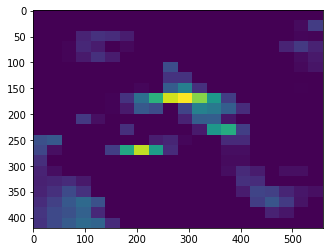

In [10]:
dst = cv2.resize(test_img, dsize=(560, 420), interpolation=cv2.INTER_AREA)
cv2.imwrite('test.jpg', dst)
print(dst.shape)
plt.imshow(dst)

(420, 560, 3)


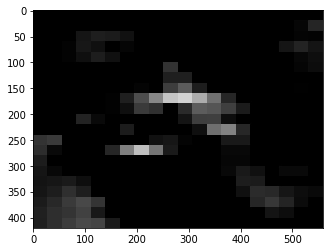

In [11]:
ref = cv2.imread('test.jpg')
# im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
print(ref.shape)
plt.imshow(ref)

In [12]:
def down_grade_images(img, factor):
    
    h, w, c = img.shape
    new_height = int(h / factor)
    new_width = int(w / factor)
    out_img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
    out_img = cv2.resize(out_img, (w, h), interpolation = cv2.INTER_LINEAR)
    # print('Saving {}'.format(file))
    cv2.imwrite('./test_down.jpg', out_img)

(420, 560, 3)


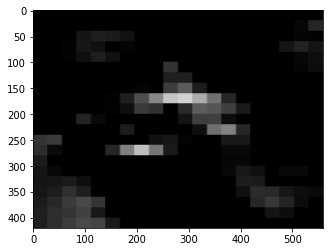

In [13]:
down_grade_images(img=ref, factor=2)
degraded = cv2.imread('test_down.jpg')
# im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
print(degraded.shape)
plt.imshow(degraded)

In [14]:
def modcrop(img,scale):
    tmpsz=img.shape
    sz=tmpsz[0:2]
    sz=sz-np.mod(sz,scale)
    img=img[0:sz[0],1:sz[1]]
    return img

def shave(image,border):
    img=image[border: -border,border:-border]
    return img

def psnr(target,ref):

    target_data=target.astype(float)
    ref_data=ref.astype(float)
    
    diff=ref_data-target_data
    diff=diff.flatten('C')
    
    rmse=math.sqrt(np.mean(diff**2.))
    psnr_value = 20 * math.log10(255./rmse)

    return psnr_value

def mse(target,ref):
    se=np.sum((target.astype('float')-ref.astype('float'))**2)
    mse=se/float(target.shape[0]*target.shape[1])
    return mse


def compare_images(target,ref):
    scores=[]
    scores.append(psnr(target,ref))
    scores.append(mse(target,ref))
    scores.append(ssim(target,ref,multichannel=True))#multichannel so that it can handle 3Dor 3 channel images RGB/BGR 
    
    return scores


In [15]:
degraded = cv2.imread('test_down.jpg')
ref = cv2.imread('test.jpg')

ref=modcrop(ref,3)
degraded=modcrop(degraded,3)
temp=cv2.cvtColor(degraded,cv2.COLOR_BGR2YCrCb)

print(temp.shape)
Y=np.zeros((1,temp.shape[0],temp.shape[1],1),dtype=float)
Y[0,:,:,0]=temp[:,:,0].astype(float)/255

pre=srcnn_model.predict(Y,batch_size=1)

pre*=255#multiplying every pixel by 255
pre[pre[:]>255]=255#any pixels >255 set it =255 to prevent any rounding errors due to multiplication
pre[pre[:]<0] =0# same reason as above
pre=pre.astype(np.uint8)#convert float back to int values

temp=shave(temp,6)#accd.to tutor it loses 3 pixels on each side so if we shave this with a border 6,we can crop it appropriately there, so it is the same size as our output
    #if not agree with tutor, use print statements to see the specific dimensions
    
    # for the first channel(Y channel), copy in the output of our network
temp[:,:,0]=pre[0,:,:,0]
    #So we are keeping the red difference and blue difference, channels 1 and 2, in this temp image which is in the YCrCb color space
    #and in the first one we are copying in our ouput,our luminiscence channel
    
#convert back to bgr
output=cv2.cvtColor(temp,cv2.COLOR_YCrCb2BGR)

(420, 557, 3)


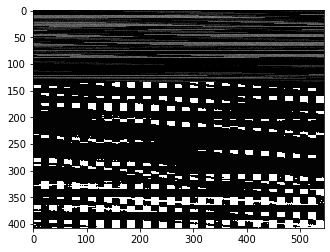

In [16]:
#emove borderfrom reference and degraded image, so that all our images(ref,degraded(low res.), and ouput(high res.)) are of the same size
ref = shave(ref.astype(np.uint8), 6)
degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
scores = []
scores.append(compare_images(degraded, ref))#degraded wrt ref
scores.append(compare_images(output, ref))#high res. output wrt ref

/app/share/anaconda3/envs/tensorflow-2.1.0/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.


In [17]:
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

Degraded Image: 
PSNR: 39.016345537332626
MSE: 24.46623043712898
SSIM: 0.984622586387768

Reconstructed Image: 
PSNR: 9.151083958383692
MSE: 23718.827671343766
SSIM: 0.07679790011795044

